# Samuel Thelin - samthe-1

## Guiding questions
1. What does teacher forcing mean?

    'Teacher forcing' means to use the ground truth output from the previous iteration/timestep, and use it as input to predict the next timestep (rather than its own predicted output). This is supposed to help the model converge faster and stabilize during training.

2. What is ridge regression? Why is it useful?

    Ridge regression is used to predict continuous values. It includes a penalty term to the loss function - this is what we want, since we want to reduce overfitting. Another factor to why Rdige regression is beneficial is because it "allows a one-shot training with virtually unlimited data". 

3. How to achieve echo state property?

    "The state of the reservoir should be uniquely defined by the fading history of the input". In most situations, when the spectral radius should be less than 1, echo state is achieved.   

4. What is Root-Mean-Square Error (RMSE)?

    RMSE is a way to evaluate the accuracy of regression models. As one can guess based off of the name, it measures the square root of the average differences between predicted and actual values, squares it, and calculates. 

In [ ]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


class EchoStateNetwork:
    def __init__(self, input_dim, reservoir_dim, output_dim, spectral_radius=0.8, reg_param=1e-8, input_scaling=1.0):
        """
        Initialize the Echo State Network.
        :param input_dim: Number of input features
        :param reservoir_dim: Number of reservoir neurons
        :param output_dim: Number of output features
        :param spectral_radius: Spectral radius to ensure echo state property
        :param reg_param: Ridge regression regularization parameter
        :param input_scaling: W^{in} scaling (want 0.2 by lab instructions)
        """
        
        #np.random.seed(42) # i used this to visualize the effect of hyperparameters, since we are getting a consistent generation of W_in and W.

        self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.reg_param = reg_param
        self.input_scaling = input_scaling

        # Initialize random weights for input-to-reservoir and reservoir
        self.W_in = np.random.uniform(-1, 1, (reservoir_dim, input_dim)) * self.input_scaling
        self.W = np.random.uniform(-1, 1, (reservoir_dim, reservoir_dim))

        # Scale the reservoir weight matrix to satisfy echo state property
        max_eigenvalue = max(abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / max_eigenvalue

        # Readout weights (trained later)
        self.W_out = None

    def _update_reservoir(self, x_t, r_prev):
        """
        Update the reservoir state.
        :param x_t: Input at time t
        :param r_prev: Previous reservoir state
        :return: Updated reservoir state
        """
        return np.tanh(np.dot(self.W_in, x_t) + np.dot(self.W, r_prev))

    def fit(self, X, Y):
        """
        Train the ESN using teacher forcing and ridge regression.
        :param X: Input time-series data (shape: [timesteps, input_dim])
        :param Y: Target time-series data (shape: [timesteps, output_dim])
        """
        timesteps = X.shape[0]
        reservoir_states = np.zeros((timesteps, self.reservoir_dim))
        r_prev = np.zeros(self.reservoir_dim)

        # Collect reservoir states using pure teacher forcing
        for t in range(timesteps):
            if t == 0:
                r_prev = self._update_reservoir(X[t], r_prev)  # Use input for first step
            else:
                r_prev = self._update_reservoir(Y[t-1], r_prev)  # Use ground truth directly
            reservoir_states[t] = r_prev

            # Debugging (print norms for the first few steps)
            #if t < 10:
            print(f"Step {t}, Input Norm: {np.linalg.norm(X[t])}, Reservoir State Norm: {np.linalg.norm(r_prev)}")

        # Reduce transient discard for simple sequences
        discard_steps = 1000

        reservoir_states = reservoir_states[discard_steps:]
        Y = Y[discard_steps:]

        # Add bias term to reservoir states
        extended_states = np.hstack([reservoir_states, np.ones((reservoir_states.shape[0], 1))])

        # Solve ridge regression for W_out
        self.W_out = np.linalg.solve(
            np.dot(extended_states.T, extended_states) + self.reg_param * np.eye(extended_states.shape[1]),
            np.dot(extended_states.T, Y)
        )

    def predict(self, X):
        """
        Predict using the trained ESN.
        :param X: Input time-series data (shape: [timesteps, input_dim])
        :return: Predicted time-series (shape: [timesteps, output_dim])
        """
        timesteps = X.shape[0]
        r_prev = np.zeros(self.reservoir_dim)
        predictions = []

        for t in range(timesteps):
            r_prev = self._update_reservoir(X[t], r_prev)
            # Add bias term
            extended_state = np.hstack([r_prev, 1])
            y_t = np.dot(self.W_out.T, extended_state)
            predictions.append(y_t)

        return np.array(predictions)
    
    def predict_autonomous(self, initial_input, timesteps, last_reservoir_state):
        """
        Generate predictions autonomously by feeding outputs back as inputs.
        :param initial_input: Initial input to kickstart the ESN (shape: [input_dim])
        :param timesteps: Number of timesteps to predict
        :param last_reservoir_state: Reservoir state from the end of training
        :return: Predicted time-series (shape: [timesteps, output_dim])
        """
        r_prev = last_reservoir_state
        predictions = []
        input_t = initial_input

        for t in range(timesteps):
            # Update reservoir state using the current input
            r_prev = self._update_reservoir(input_t, r_prev)
            
            # Add bias term and compute output
            extended_state = np.hstack([r_prev, 1])
            y_t = np.dot(self.W_out.T, extended_state)
            predictions.append(y_t)
            
            # Use the output as the next input
            input_t = y_t

        return np.array(predictions)


[[0.        ]
 [0.12370198]
 [0.23971277]
 ...
 [0.11083959]
 [0.22801809]
 [0.33101952]]
Step 0, Input Norm: 0.0, Reservoir State Norm: 0.0
Step 1, Input Norm: 0.24740395925452294, Reservoir State Norm: 0.0
Step 2, Input Norm: 0.479425538604203, Reservoir State Norm: 0.45708256004340125
Step 3, Input Norm: 0.6816387600233341, Reservoir State Norm: 0.991056789548967
Step 4, Input Norm: 0.8414709848078965, Reservoir State Norm: 1.5700338477369495
Step 5, Input Norm: 0.9489846193555862, Reservoir State Norm: 2.155067782154608
Step 6, Input Norm: 0.9974949866040544, Reservoir State Norm: 2.7071490939460037
Step 7, Input Norm: 0.9839859468739369, Reservoir State Norm: 3.1975670325968037
Step 8, Input Norm: 0.9092974268256817, Reservoir State Norm: 3.595625464567085
Step 9, Input Norm: 0.7780731968879212, Reservoir State Norm: 3.8699681676796436
Step 10, Input Norm: 0.5984721441039564, Reservoir State Norm: 4.0006897122909715
Step 11, Input Norm: 0.3816609920523317, Reservoir State Norm: 3.

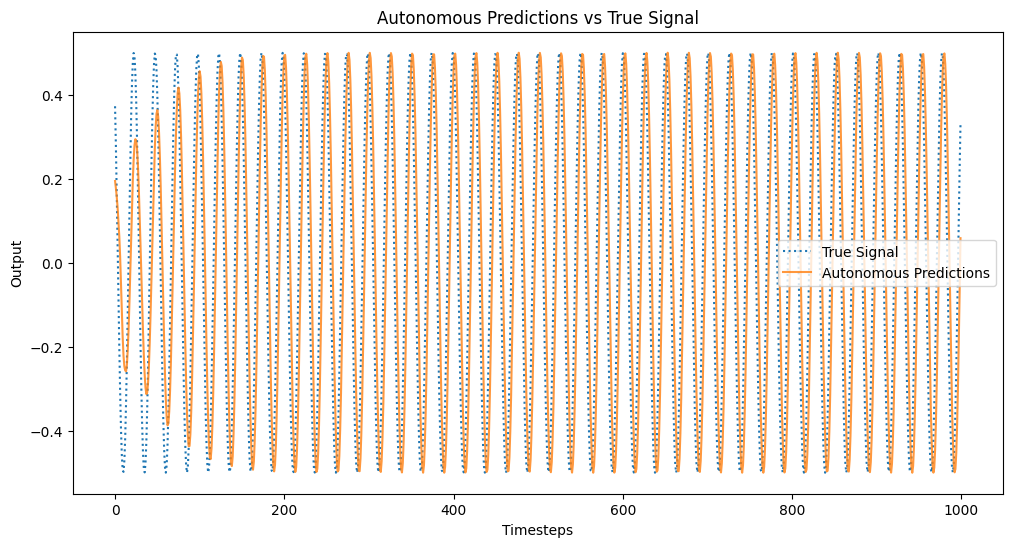

In [ ]:
# Define the sinusoidal signal
timesteps = 4000
train_size = 3000
test_size = timesteps - train_size

# Generate the dataset
n = np.arange(timesteps)
X = (np.sin(n / 4)).reshape(-1, 1)  # Input: sin(n/4)
Y = (0.5 * np.sin(n / 4)).reshape(-1, 1)  # Target: 0.5sin(n/4)
print(Y)
# Split into training and testing sets
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]
# Autonomous mode: Generate future predictions
initial_input = X_test[0]  # Use the first test input as the starting point
timesteps_to_generate = 1000  # Generate predictions for the full test set length
reservoir_dim = 1000
esn = EchoStateNetwork(input_dim=1, reservoir_dim=reservoir_dim, output_dim=1, input_scaling=0.2, spectral_radius=0.8)
# Train the ESN
esn.fit(X_train, Y_train)

# Use the last reservoir state from training
last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(reservoir_dim))

# Autonomous predictions
initial_input = Y_train[-1]  # Last ground truth value from training
Y_autonomous = esn.predict_autonomous(initial_input, 1000, last_reservoir_state)

rmse = np.sqrt(mean_squared_error(Y_test, Y_autonomous))
print(f"Test RMSE: {rmse:.6f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(Y_autonomous, label="Autonomous Predictions", alpha=0.8)
plt.title("Autonomous Predictions vs True Signal")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()



Experiment 1/10
Step 0, Input Norm: 0.0, Reservoir State Norm: 0.0
Step 1, Input Norm: 0.24740395925452294, Reservoir State Norm: 0.0
Step 2, Input Norm: 0.479425538604203, Reservoir State Norm: 0.9138275456139917
Step 3, Input Norm: 0.6816387600233341, Reservoir State Norm: 1.9778806527026478
Step 4, Input Norm: 0.8414709848078965, Reservoir State Norm: 3.1196867561240222
Step 5, Input Norm: 0.9489846193555862, Reservoir State Norm: 4.247778307767174
Step 6, Input Norm: 0.9974949866040544, Reservoir State Norm: 5.2695539485906036
Step 7, Input Norm: 0.9839859468739369, Reservoir State Norm: 6.116477342024579
Step 8, Input Norm: 0.9092974268256817, Reservoir State Norm: 6.732417888050029
Step 9, Input Norm: 0.7780731968879212, Reservoir State Norm: 7.0780379650618075
Step 10, Input Norm: 0.5984721441039564, Reservoir State Norm: 7.140249389372155
Step 11, Input Norm: 0.3816609920523317, Reservoir State Norm: 6.964440415301683
Step 12, Input Norm: 0.1411200080598672, Reservoir State Nor

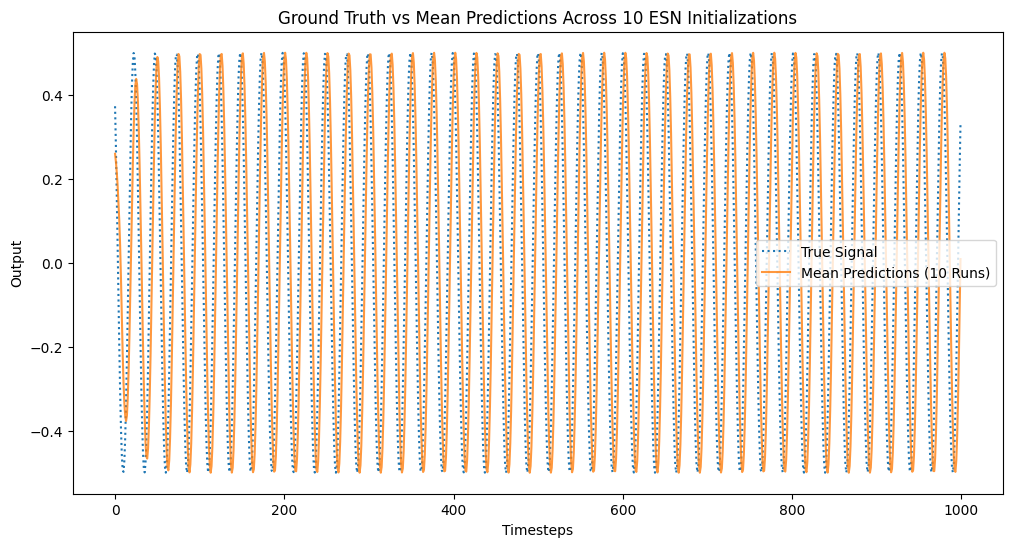

In [ ]:
from sklearn.metrics import mean_squared_error

# Repeat the experiment for 10 different initializations
num_experiments = 10
predictions_list = []
rmse_values = []

for i in range(num_experiments):
    print(f"Experiment {i + 1}/{num_experiments}")
    
    # Initialize and train a new ESN
    esn = EchoStateNetwork(input_dim=1, reservoir_dim=1000, output_dim=1, spectral_radius=0.8, input_scaling=0.2)
    esn.fit(X_train, Y_train)
    
    # Get the last reservoir state from training
    last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(1000))
    
    # Generate autonomous predictions
    initial_input = Y_train[-1]  # Last ground truth value from training
    Y_autonomous = esn.predict_autonomous(initial_input, 1000, last_reservoir_state)
    
    # Store predictions
    predictions_list.append(Y_autonomous)
    
    # Calculate RMSE for this experiment
    rmse = np.sqrt(mean_squared_error(Y_test, Y_autonomous))
    rmse_values.append(rmse)
    print(f"RMSE for Experiment {i + 1}: {rmse:.6f}")

# Compute mean predictions across all experiments
mean_predictions = np.mean(predictions_list, axis=0)

# Compute RMSE for the mean prediction
mean_rmse = np.sqrt(mean_squared_error(Y_test, mean_predictions))
print(f"\nMean RMSE Across All Predictions: {mean_rmse:.6f}")

# Plot ground truth vs mean predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(mean_predictions, label="Mean Predictions (10 Runs)", alpha=0.8)
plt.title("Ground Truth vs Mean Predictions Across 10 ESN Initializations")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()


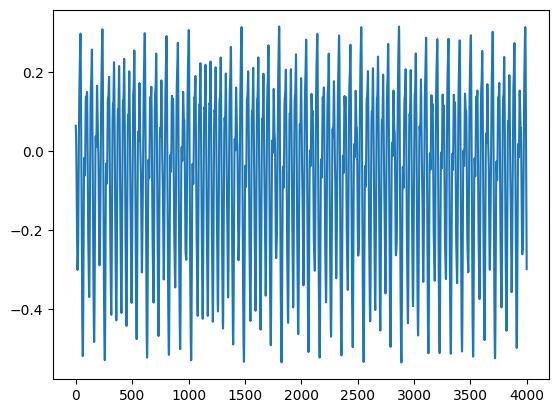

In [21]:
def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a)   )  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements


length=4000 # duration of the series
tau=17 # delay in the equation

y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

In [ ]:
# visualize how our training work. when 1, predict 2 and so on....
a=[1,2,3,4,5,6,7,8,9,10]
print(a[:-1])
print(a[1:])

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 3, 4, 5, 6, 7, 8, 9, 10]


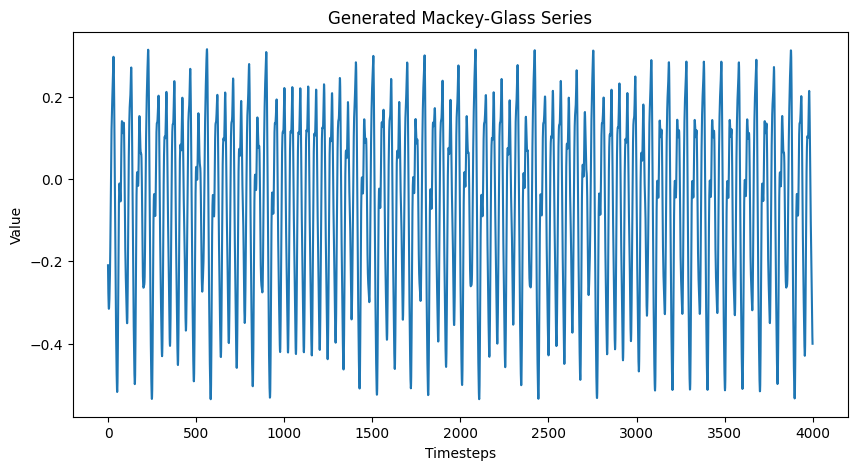

Step 0, Input Norm: 0.20950096725500905, Reservoir State Norm: 1.931259209532996
Step 1, Input Norm: 0.24698594987161662, Reservoir State Norm: 2.8907062881085777
Step 2, Input Norm: 0.27687553185245983, Reservoir State Norm: 3.610531212374224
Step 3, Input Norm: 0.2982049941047221, Reservoir State Norm: 4.255121362750488
Step 4, Input Norm: 0.3108199712771813, Reservoir State Norm: 4.81167071118186
Step 5, Input Norm: 0.3152409939980426, Reservoir State Norm: 5.260249228163956
Step 6, Input Norm: 0.3125107926097017, Reservoir State Norm: 5.596563824411743
Step 7, Input Norm: 0.30398307760800564, Reservoir State Norm: 5.802119018918663
Step 8, Input Norm: 0.29101782435686796, Reservoir State Norm: 5.868509572004203
Step 9, Input Norm: 0.27465684730868967, Reservoir State Norm: 5.848665744231591
Step 10, Input Norm: 0.2552986140122543, Reservoir State Norm: 5.716479585465142
Step 11, Input Norm: 0.23237767715251356, Reservoir State Norm: 5.505208556927822
Step 12, Input Norm: 0.20426857

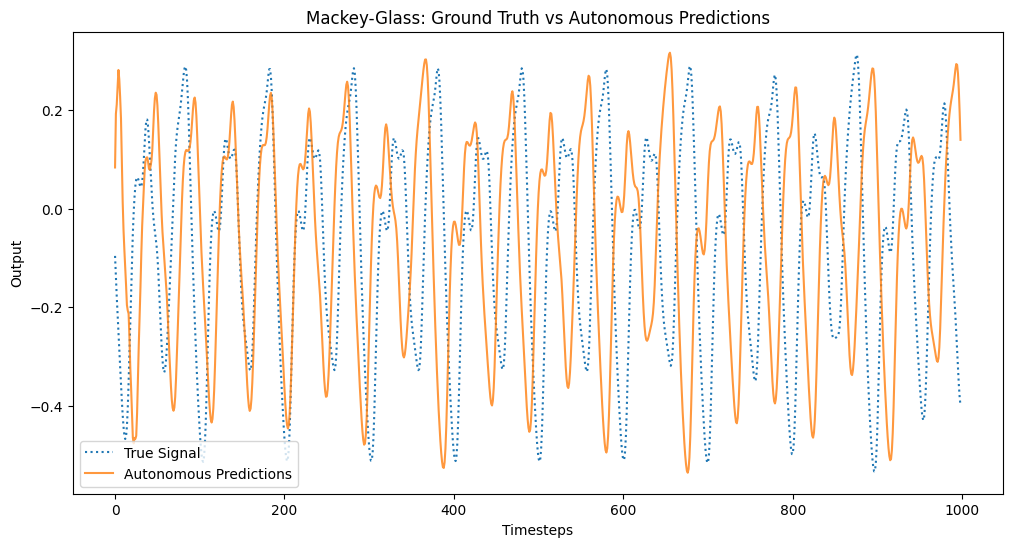

In [134]:
# Generate Mackey-Glass Series
length = 4000
tau = 17
y = mackey_glass(tau, length)

# Plot the Mackey-Glass series
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.title("Generated Mackey-Glass Series")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.show()

# Split data into training and testing
train_size = 3000
test_size = length - train_size
X = y[:-1].reshape(-1,1)
Y = y[1:].reshape(-1,1)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Define ESN parameters
reservoir_dim = 1000
spectral_radius = 0.95
input_scaling = 0.5

# Initialize and train the ESN
esn = EchoStateNetwork(input_dim=1, reservoir_dim=reservoir_dim, output_dim=1,
                       spectral_radius=spectral_radius, input_scaling=input_scaling)
esn.fit(X_train, Y_train)

# Debug: Inspect reservoir state at last training step
last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(reservoir_dim))
print(f"Reservoir state norm (last training step): {np.linalg.norm(last_reservoir_state)}")

# Autonomous prediction
initial_input = Y_train[-1]  # Start with the last ground truth value
Y_autonomous = esn.predict_autonomous(initial_input, 999, last_reservoir_state)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, Y_autonomous))
print(f"Test RMSE: {rmse:.6f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(Y_autonomous, label="Autonomous Predictions", alpha=0.8)
plt.title("Mackey-Glass: Ground Truth vs Autonomous Predictions")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()


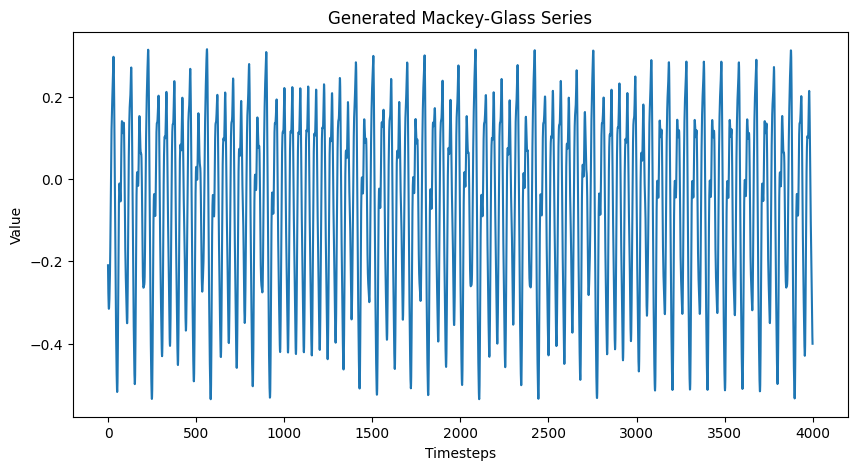

Experiment 1/10
Step 0, Input Norm: 0.20950096725500905, Reservoir State Norm: 1.5462317190087331
Step 1, Input Norm: 0.24698594987161662, Reservoir State Norm: 2.356385980129544
Step 2, Input Norm: 0.27687553185245983, Reservoir State Norm: 2.98918996326323
Step 3, Input Norm: 0.2982049941047221, Reservoir State Norm: 3.5808551538094804
Step 4, Input Norm: 0.3108199712771813, Reservoir State Norm: 4.124598908988025
Step 5, Input Norm: 0.3152409939980426, Reservoir State Norm: 4.593575578248286
Step 6, Input Norm: 0.3125107926097017, Reservoir State Norm: 4.978730649177554
Step 7, Input Norm: 0.30398307760800564, Reservoir State Norm: 5.2550713122229125
Step 8, Input Norm: 0.29101782435686796, Reservoir State Norm: 5.4007529921679165
Step 9, Input Norm: 0.27465684730868967, Reservoir State Norm: 5.472686609080324
Step 10, Input Norm: 0.2552986140122543, Reservoir State Norm: 5.422807698375474
Step 11, Input Norm: 0.23237767715251356, Reservoir State Norm: 5.285009423119321
Step 12, Inp

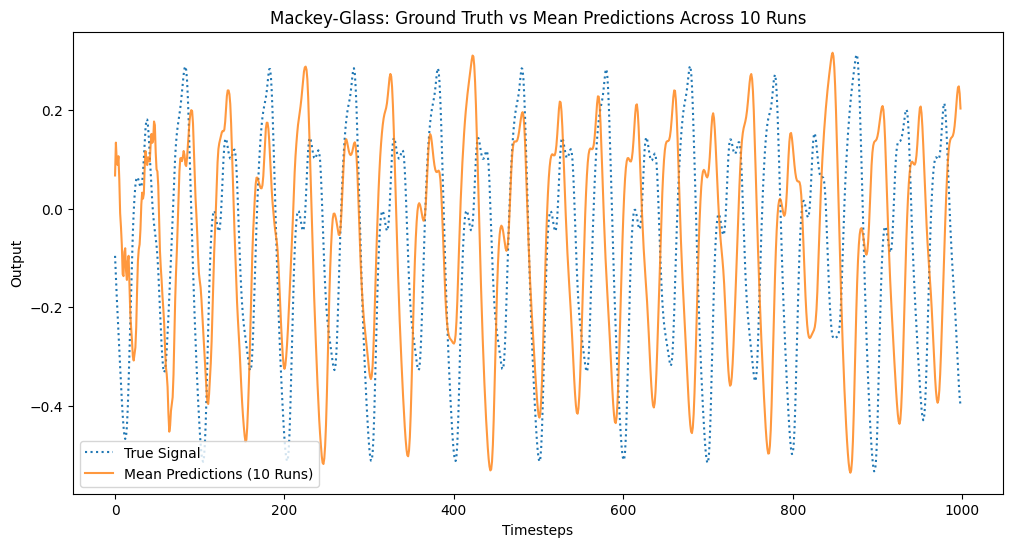

Individual RMSEs: [np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255), np.float64(0.3029988554277255)]
Mean RMSE: 0.302999


In [ ]:
from sklearn.metrics import mean_squared_error

# Generate Mackey-Glass Series
length = 4000
tau = 17
y = mackey_glass(tau, length)

# Plot the Mackey-Glass series
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.title("Generated Mackey-Glass Series")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.show()

# Split data into training and testing
train_size = 3000
test_size = length - train_size
X = y[:-1].reshape(-1, 1)  # Inputs: y(t-1)
Y = y[1:].reshape(-1, 1)   # Targets: y(t)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Define ESN parameters
reservoir_dim = 1000

# Repeat the experiment for 10 different initializations
num_experiments = 10
predictions_list = []
rmse_list = []

for exp in range(num_experiments):
    print(f"Experiment {exp + 1}/{num_experiments}")
    
    # Initialize and train the ESN
    esn = EchoStateNetwork(input_dim=1, reservoir_dim=reservoir_dim, output_dim=1, spectral_radius=0.8, input_scaling=0.2)
    esn.fit(X_train, Y_train)
    
    # Debug: Inspect reservoir state at last training step
    last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(reservoir_dim))
    print(f"Reservoir state norm (last training step): {np.linalg.norm(last_reservoir_state)}")
    
    # Autonomous prediction
    initial_input = Y_train[-1]  # Start with the last ground truth value
    Y_autonomous = esn.predict_autonomous(initial_input, 999, last_reservoir_state)
    
    # Store predictions
    predictions_list.append(Y_autonomous)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(Y_test, Y_autonomous))
    rmse_list.append(rmse)
    print(f"RMSE for Experiment {exp + 1}: {rmse:.6f}")

# Compute mean predictions across experiments
mean_predictions = np.mean(predictions_list, axis=0)

# Compute RMSE for the mean prediction
mean_rmse = np.sqrt(mean_squared_error(Y_test, mean_predictions))
print(f"\nMean RMSE Across All Predictions: {mean_rmse:.6f}")

# Plot ground truth vs mean predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(mean_predictions, label="Mean Predictions (10 Runs)", alpha=0.8)
plt.title("Mackey-Glass: Ground Truth vs Mean Predictions Across 10 Runs")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()

# Print RMSE summary
print(f"Individual RMSEs: {rmse_list}")
print(f"Mean RMSE: {mean_rmse:.6f}")

# 4. Time-series classification with ESNs

In [145]:
import pandas as pd
import csv

print('importing training data:\n===============================================================================')
training_df = pd.read_csv('data/UCRArchive_2018/SwedishLeaf/SwedishLeaf_TRAIN.tsv', sep='\t')
print(training_df.sample(5))
print(training_df.shape)

print('\nimporting test data:\n================================================================================')
testing_df = pd.read_csv('data/UCRArchive_2018/SwedishLeaf/SwedishLeaf_TEST.tsv', sep='\t')
print(testing_df.sample(5))
print(testing_df.shape)


importing training data:
      4  1.5247497  1.5381197  1.4107898  1.2443998  1.0394698  0.86867588  \
387   5   1.676080   1.573860   1.379580   1.235690   1.045600    0.956762   
160   9   2.047590   1.903690   1.676350   1.458810   1.197470    1.037490   
395  12   2.752500   2.411150   2.025360   1.645370   1.264960    0.951810   
21   10   1.745880   1.314150   0.839029   0.381859   0.054036   -0.306075   
102  10   2.040559   1.835569   1.491529   1.097680   0.703767    1.041660   

     0.66425693  0.48980096  0.26854901  ...  0.85770788  0.7606489  \
387    0.777544    0.645710    0.667172  ...    0.593436   0.725262   
160    0.812902    0.640548    0.535703  ...    0.218930   0.415515   
395    0.644305    0.280085   -0.060100  ...    0.023439   0.081640   
21     0.154971    0.545572    0.953089  ...    0.840135   1.409180   
102    1.304779    1.508209    1.222850  ...    0.728145   1.129000   

     0.52103296  0.36217599  0.56148895  0.74166991  0.95520986  1.0967598  \
3